In [1]:
# "simple" implementation of CNN for MNIST handwriting dataset classification
# input: 28px x 28px grayscale image of a handwritten charachter
# output: classification label, an integer in [0,9] 
#
# uses data available in tensorflow_datasets (tfds)
# stores data as a tensorflow.data.Dataset object

In [2]:
# required imports
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import IPython.display as display
#from PIL import Image                 # NOTE: PIL is not maintained but Pillow is, and this line works with it...
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# load MNIST data from tensorflow_datasets
# data will download from the internet on the first run, retrieved from disk subsequently
# note: as_supervised option converts to tuple format (data,label) instead of dictionary format, not entirely sure that this is necessary...
(ds_train,ds_test), ds_info = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, data_dir='c:\\tensorflow-datasets',as_supervised=True,with_info=True)

# ensure that data are in correct format
assert isinstance(ds_train, tf.data.Dataset)
assert isinstance(ds_test, tf.data.Dataset)

# display TRAINING dataset details and show number of elements
print(ds_train)
#print(sum(1 for i in ds_train)) # too slow, plus it "uses up" iterator
print('Size of train set: ' + np.array2string(tf.data.experimental.cardinality(ds_train).numpy()))
print('Size of train set: ' + str(ds_info.splits['train'].num_examples)) # better?

# display TRAINING dataset details and show number of elements
print(ds_test)
#print(sum(1 for i in ds_test)) # too slow, plus it "uses up" iterator
print('Size of test set: ' + np.array2string(tf.data.experimental.cardinality(ds_test).numpy()))
print('Size of test set: ' + str(ds_info.splits['test'].num_examples)) 

<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>
Size of train set: 60000
Size of train set: 60000
<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>
Size of test set: 10000
Size of test set: 10000


In [4]:
# copy training dataset so we can look at some samples
# if we don't copy it we will "use up" the iterator, and it can't just be reset
ds_explore = ds_train
myit = iter(ds_explore)

True Label: 0


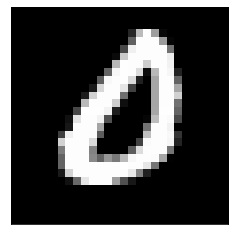

In [5]:
# display ONE image from training set
# i.e. practice extracting a single image from the iterator and displaying with matplotlib
thisInstance = next(myit)
fig = plt.imshow(thisInstance[0].numpy().squeeze(),cmap='gray', vmin=0, vmax=255)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
#img = Image.fromarray(next(myit)["image"])
#img.show
print('True Label: ' + np.array2string(thisInstance[1].numpy()) )

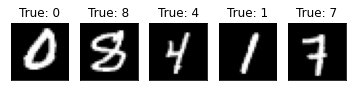

In [6]:
# extract MULTIPLE images from training set
fig,sp_axes = plt.subplots(1,5)
subplotIdx = 0
for inst in ds_explore.take(5):
    sp_axes[subplotIdx].imshow(inst[0].numpy().squeeze(),cmap='gray',vmin=0,vmax=255)
    sp_axes[subplotIdx].get_xaxis().set_visible(False)
    sp_axes[subplotIdx].get_yaxis().set_visible(False)
    sp_axes[subplotIdx].set_title( 'True: ' + np.array2string(inst[1].numpy()) )
    subplotIdx += 1

In [7]:
# now, actually build the network
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [8]:
# flatten and add dense output layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [9]:
# compile the model, specifying optimization strategy, loss function, and reporting metric(s)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
# convert TRAINING dataset to float datatype, shuffle + batch it, and cache for efficiency
# directly from https://www.tensorflow.org/datasets/keras_example
def normalize_img(image, label):   
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)  # data need to be in float32 format, given as uint8
ds_train = ds_train.cache()   # cache dataset for more efficient shuffling and prevent reloading in each epoch
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)  # shuffle with buffer set to same size as dataset (ideal)
ds_train = ds_train.batch(128)   # batch(N) -> arrange into batches of size N elements each
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE) # performance enhancement https://www.tensorflow.org/guide/data_performance#prefetching

In [11]:
# convert TESTING dataset to float datatype, batch it, and cache for efficiency
# directly from https://www.tensorflow.org/datasets/keras_example
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)   # batch(N) -> arrange into batches of size N elements each
ds_test = ds_test.cache()      # cache dataset to prevent reloading in each epoch
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)  # performance enhancement https://www.tensorflow.org/guide/data_performance#prefetching

In [12]:
# train model in batches and epochs
# if not batched this will give ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [28, 28, 1]
history = model.fit(ds_train,epochs=10,validation_data=ds_test)

Epoch 1/10
469/469 [==============================] - 25s 53ms/step - loss: 0.2448 - accuracy: 0.9263 - val_loss: 0.0699 - val_accuracy: 0.9777
Epoch 2/10
469/469 [==============================] - 27s 58ms/step - loss: 0.0585 - accuracy: 0.9816 - val_loss: 0.0397 - val_accuracy: 0.9869
Epoch 3/10
469/469 [==============================] - 27s 58ms/step - loss: 0.0420 - accuracy: 0.9869 - val_loss: 0.0358 - val_accuracy: 0.9882
Epoch 4/10
469/469 [==============================] - 27s 58ms/step - loss: 0.0318 - accuracy: 0.9895 - val_loss: 0.0350 - val_accuracy: 0.9875
Epoch 5/10
469/469 [==============================] - 28s 59ms/step - loss: 0.0259 - accuracy: 0.9920 - val_loss: 0.0340 - val_accuracy: 0.9879
Epoch 6/10
469/469 [==============================] - 30s 63ms/step - loss: 0.0230 - accuracy: 0.9925 - val_loss: 0.0272 - val_accuracy: 0.9911
Epoch 7/10
469/469 [==============================] - 31s 67ms/step - loss: 0.0197 - accuracy: 0.9937 - val_loss: 0.0297 - val_accuracy: